# Notebook for testing transition probability functions with a two-state model
#### Brandon Chan | August 2020

Run cells under "Step Zero: Define Functions" before running model. This notebook was written to more "easily" prototype and debug the addition of new transition probability functions without modifying the source code directly. As such, code from markov_modeling.py and model_helpers.py were "unpacked" and put into cells. Aware that this isn't the most elegant solution but for development it works and saves time from saving modifications in the source code and reloading it in a notebook.

### Import packages

In [1]:
import pandas as pd # Dataframe structure and reading of excel files
import numpy as np # Scientific computing - used for n-dimensional arrays, numerical functions
import matplotlib.pyplot as plt # Plotting package
import seaborn as sns # Another plotting package
import os # for file path things
from time import perf_counter, strftime
import math
from scipy import stats

### Read in model specifications from excel doc

In [2]:
#---------------------------------------------------------------------------------------------------
# Read in excel workbook and assign each sheet to a dataframe
#---------------------------------------------------------------------------------------------------
excel_book = pd.ExcelFile('../model_specifications/test_parameters_td.xlsx')

transitions_df = pd.read_excel(excel_book, 'transitions')
specification_df = pd.read_excel(excel_book, 'specification', header=None, index_col=0)

# Specification of variables regarding states in model
unique_states = transitions_df['start_state'].unique().tolist()

### Checking out specifications of the model

In [3]:
transitions_df

,start_state,end_state,type,parameter_1,parameter_2
0,treatment,treatment,residual,NaN,NaN
1,treatment,death,time_dependent_gompertz,-1.362408,-0.336339
2,death,death,constant,1.000000,NaN


In [4]:
specification_df

,1
0,
max_iterations,500
time_horizon,10
cycle_length,30
discount_rate,0.015
name_start_state,treatment


### Run model

In [7]:
pop_base, cost_base, util_base = run_model('../model_specifications/test_parameters_td.xlsx', save=False, model_name='test_base')

file and parameters loaded...
beginning iterations...
model done...
total time: 4.9 seconds || mean time per iteration: 0.01 seconds
calculating costs and utilities...
done costs and utilities...



### Plot population movement over the time horizon to validate behavior (for 1 iteration)

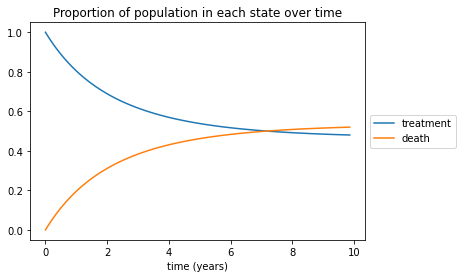

In [8]:
df = pd.DataFrame(data=pop_base[0,:,:].transpose(), columns=unique_states)
df = df.reset_index().rename(columns={'index': 'time'})
df.loc[:,'time'] = df.time.apply(lambda x: (x*30)/365)
df.set_index('time').plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('time (years)')
plt.title('Proportion of population in each state over time')
plt.show()
plt.show()

### Diagnosis of probabilistic changes over iteratrions
Look at variation in proportion of population at each time step?

In [2]:
# TODO

# Step Zero: Define Functions

## 1) From model_helpers.py 

In [5]:
#---------------------------------------------------------------------------------------------------
# File IO
#---------------------------------------------------------------------------------------------------
def read_file(filepath):
    model_specification_file = pd.ExcelFile(filepath)
    check_excel_file(model_specification_file) # Run checks
    return model_specification_file

def check_excel_file(excel_book):
    '''
    Excel file Q/A - checking for specification errors
    If error is detected, an exception will be raised (printed to console) and the program will terminate
    '''
    # Separate each sheet in the excel book
    transitions_df = pd.read_excel(excel_book, 'transitions')
    costs_df = pd.read_excel(excel_book, 'costs')
    utilities_df = pd.read_excel(excel_book, 'utilities')
    specification_df = pd.read_excel(excel_book, 'specification', header=None, index_col=0) # TODO:// add specification checks

    # Specification of variables regarding states in model
    start_state_names = transitions_df['start_state'].unique().tolist()
    end_state_names = transitions_df['end_state'].unique().tolist()
    unique_states = list(set(start_state_names+end_state_names))
    
    # Check only one unique start-end state pair is defined. (ie. no repeats/multiples of the same transition)
    check_multiple = transitions_df.groupby(['start_state','end_state']).size().reset_index().rename(columns={0:'count'})
    if (check_multiple['count'] > 1).any():
        print(check_multiple.loc[check_multiple['count'] > 1])
        raise ValueError('Multiple identical defined transitions found. Please check transitions sheet in input excel document')

    # Checks that each state has an entry/exit
    # TODO: consider that its possible for the entry/start state to be non-reenterable
    #       with that in mind its more logical that all states must have an outbound rather than enforcing entry
    #if np.setdiff1d(start_state_names, end_state_names).shape[0] > 0:
    #    raise ValueError('State missing exit:',np.setdiff1d(start_state_names, end_state_names).tolist(),'please check transitions sheet in excel document')
    if np.setdiff1d(end_state_names, start_state_names).shape[0] > 0:
        raise ValueError('State missing entry:',np.setdiff1d(end_state_names, start_state_names).tolist(),'please check transitions sheet in excel document')
            
    # Check for missing costs 
    if np.setdiff1d(unique_states, costs_df['state'].tolist()).shape[0] > 0:
        raise ValueError('Missing cost value for state(s):',np.setdiff1d(unique_states, costs_df['state'].tolist()),'please check cost sheet in excel document')

    # Check for missing utilities
    if np.setdiff1d(unique_states, utilities_df['state'].tolist()).shape[0] > 0:
        raise ValueError('Missing utility value for state(s):',np.setdiff1d(unique_states, utilities_df['state'].tolist()),'please check utilities sheet in excel document')
        
    # Check specification parameters
    if int(specification_df.loc['max_iterations'].values[0]) < 1:
        raise ValueError('Invalid number of model iterations. Needs to be greater than or equal to 1')
    if specification_df.loc['cycle_length'].values[0] > specification_df.loc['time_horizon'].values[0] * 365:
        raise ValueError('Invalid cycle length or time horizon. Cycle length must be smaller than horizon')
    if specification_df.loc['name_start_state'].values[0] not in unique_states:
        raise ValueError('Start state must be a valid defined state in "transitions" sheet. Please check. Invalid entry:',specification_df.loc['name_start_state'].values[0])
    if specification_df.loc['discount_rate'].values[0] < 0 or specification_df.loc['discount_rate'].values[0] > 1:
        raise ValueError('Invalid Discount Rate. Must be represented as a number between 0 and 1.')


#---------------------------------------------------------------------------------------------------
# Helper functions for selecting transition probabilities
# 
# This is where you'd add a new function for calculating transition probabilities. More details in 
# CLEO confluence docs online.
#---------------------------------------------------------------------------------------------------
# Not sure how to use yet... but ok.
def get_dirchlet(parameters):
    #Samples a value from the dirchlet distribution based on input parameters
    return np.random.dirichlet(parameters,1)

def get_gamma(mean, variance):
    '''
    Samples a value from the gamma distribution based on an input mean and variance
    Inputs: mean = mean
            variance = variance
    Output: A float between 0 and 1 sampled from the beta distribution defined
            by the input parameters
    '''
    # TODO: Error checking (look at wikipedia too) - consider moving out when checking the spreasheet. (all should be specified correctly before running)
    # mean-var > 1?
    # Actually used for sampling utility or cost?
    alpha = (mean**2)/(variance**2)  
    beta = (variance**2)/mean
    return np.random.gamma(alpha, beta)

def get_beta(mean, variance):
    '''
    Samples a value from the beta distribution based on an input mean and variance
    Inputs: mean = mean
            variance = variance
    Output: A float between 0 and 1 sampled from the beta distribution defined
            by the input parameters
    '''
    # TODO: Error checking (look at wikipedia too) - consider moving out when checking the spreasheet. (all should be specified correctly before runnin
    # if mean - close to 1 and 0 may return errors
    # if variance is > mean - maybe issues
    # Actually used for sampling utility or cost?
    alpha = mean*((mean*(1-mean)/variance**2) - 1) #(((1-mean)/variance) - (1/mean)) * mean**2  
    beta = (1-mean)*(mean/variance**2*(1-mean) - 1) #alpha * ((1/mean) - 1)
    return np.random.beta(alpha, beta)

def get_time_dependent_weibull(const, p, cycle, cycle_length):
    '''
    Obtains the transition probability for a time-dependent transition by sampling the approximated function 
    at the given time interval. 
    
    Implementation of formula: tp(t_u) = 1 - S(t)/S(t-u) from "Decision Modelling for Health Economic Evaluation" by Briggs et.al
    Based on survival functions outlined here: https://www.stata.com/manuals13/ststreg.pdf (Page 6.)
    
    Inputs: const = regression constant (as output from a PH fitted weibull in stata)
            p = paramter p (as output from a PH fitted weibull in stata)
            cycle = the current cycle of the model (ie. cycle i in 1:max_num_cycles)
            cycle_length = the length of a cycle in days. 
    Output: tdtp = A float between 0 and 1 denoting the time-dependent transition probability from A to B 
            based on the input parameters

    Note* : Assumes weibull fitted to survival curve at a time scale of YEARS on x-axis.
    '''
    lmbda = math.exp(const)

    # adjusts to yearly x-axis. subtract 1 from t1 as model "starts at time 1" however first transition calculation is based off of t0 and t1
    t1 = ((cycle-1)*cycle_length) / 365
    t2 = ((cycle)*cycle_length) / 365
    
    tdtp = 1 - ((math.exp(-lmbda*(t2**p))) / (math.exp(-lmbda*(t1**p))))

    if tdtp > 1 or tdtp < 0:
        raise ValueError('Transition sampled is greater than 1 or less than 0. Sampled value:',round(tdtp,4),'at cycle:',cycle)
    
    return tdtp

def get_time_dependent_gompertz(const, gamma, cycle, cycle_length):
    '''
    Obtains the transition probability for a time dependent transition represented as a gompertz
    
    Implementation of formula: tp(t_u) = 1 - S(t)/S(t-u) from "Decision Modelling for Health Economic Evaluation" by Briggs et.al
    Based on survival functions outlined here: https://www.stata.com/manuals13/ststreg.pdf (Page 6.)
    
    Inputs: const = the regression constant (as output from a PH fitted gompertz in stata)
            gamma = parameter gamma (as output from a PH gompertz fitted in stata)
            cycle = the current cycle of the model (ie. cycle i in 1:max_num_cycles)
            cycle_length = the length of a cycle in days.
    Output: tdtp = A float between 0 and 1 denoting the time-dependent transition probability from A to B 
            based on the input parameters

    Note** : Assumes gompertz fitted to survival curve at a time scale of YEARS on x-axis.
    '''
    lmbda = math.exp(const) #because lambda is a key term in python, lmbda is used to name the variable

    t1 = ((cycle-1)*cycle_length) / 365
    t2 = ((cycle)*cycle_length) / 365

    tdtp = 1 - ((math.exp(-lmbda*gamma**-1*(math.exp(gamma*t2)-1))) / (math.exp(-lmbda*gamma**-1*(math.exp(gamma*t1)-1))))

    if tdtp > 1 or tdtp < 0:
        raise ValueError('Transition sampled is greater than 1 or less than 0. Sampled value:',round(tdtp,4),'at cycle:',cycle)
    
    return tdtp
    

def calculate_residual(matrix, state_index):
    '''
    Function that calculates the residual of all states in the matrix passed
    Inputs: matrix = n x n numpy array representing the transition matrix of the model
            state_index = an integer representing the row of the state that we wish to calculate the residual of
    Output: residual of the outbound transitions
    '''
    row_sum = matrix[state_index, :].sum()
    residual = 1 - row_sum
    
    # Error checking
    if residual < 0:
        raise ValueError('Error: residual is negative', round(residual,5))
        
    return residual

def set_transition(transition_type, **kwargs):
    '''
    Function that serves as a switch for a number of transition-probability retriever functions
    Inputs: transition_type = string that denotes which function to redirect params to
            kwargs = a number of keyword arguments provided to the function. Different transition types require different
                     arguments. See code for details. Error is raised when incorrect arguments are provided for a transition type.
    Output: transition probability sampled/assigned according to the transition_type input
    '''
    if transition_type == 'beta':
        if not all (parameter in kwargs for parameter in ('a','b')):
            raise ValueError('Incorrect inputs specified for beta. Need a and b.')
        return np.random.beta(kwargs['a'], kwargs['b'])
    elif transition_type == 'gamma':
        if not all (parameter in kwargs for parameter in ('a','b')):
            raise ValueError('Incorrect inputs specified for gamma. Need a and b.')
        return get_gamma(kwargs['a'], kwargs['b']) 
    elif transition_type == 'time_dependent_weibull':
        if not all (parameter in kwargs for parameter in ('const','ancillary','cycle','cycle_length')):
            raise ValueError('Incorrect inputs specified for time dependent. Need const, p, cycle, and cycle_length.')
        return get_time_dependent_weibull(kwargs['const'],kwargs['ancillary'],kwargs['cycle'],kwargs['cycle_length'])
    elif transition_type == 'time_dependent_gompertz':
        if not all (parameter in kwargs for parameter in ('const','ancillary','cycle','cycle_length')):
            raise ValueError('Incorrect inputs specified for time dependent. Need const, gamma, cycle, and cycle_length.')
        return get_time_dependent_gompertz(kwargs['const'],kwargs['ancillary'],kwargs['cycle'],kwargs['cycle_length'])
    elif transition_type == 'constant':
        if 'transition' not in kwargs:
            raise ValueError('Incorrect inputs specified for constant:', kwargs,'Only need 1: transition')
        return kwargs['transition']
    elif transition_type == 'residual':
        if not all (parameter in kwargs for parameter in ('transition_matrix','update_index')):
            raise ValueError('Incorrect inputs specified for residual calculation. Need transition_matrix and update_index')
        return calculate_residual(kwargs['transition_matrix'], kwargs['update_index'])
    else:
        raise ValueError('Invalid transition type provided:',str(transition_type))


#---------------------------------------------------------------------------------------------------
# Helper functions related to operations on the transition matrix
#---------------------------------------------------------------------------------------------------
def check_row_sums(matrix):
    '''
    Function that serves soley as a check that all outbound probabilities sum to 1
    Input: matrix = transition matrix of dimensions [num_states x num_states]
    Output: None. Will throw an error and terminate runtime if condition not met
    '''
    row_sums = np.round(matrix.sum(axis=1), 5) # rounding to 5 significant digits for tolerance for close to 1 values
    if np.any(row_sums != 1):
        print(matrix)
        print(row_sums)
        raise ValueError('Error: transitions do no add to 1. Suggest using normalize_transitions()...')
    
def normalize_transitions(matrix):
    '''
    Function that rescales/normalizes the outbound transtions (row-wise) to have a sum of 1
    Input: matrix = transition matrix of dimensions [num_states x num_states]
    Output: matrix rescaled to have each row sum to 1 and each outbound transition scaled appropriately 
    '''
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis] # need newaxis to "reshape" the array so its properly applied

#---------------------------------------------------------------------------------------------------
# Other helper functions
#---------------------------------------------------------------------------------------------------
def check_model_population(pop):
    '''
    Function to check that the entire popoulation is still in the model (ie. no disappearances)
    Input: pop = [1 x number_of_states] numpy array 
    Output: None - raises error if does not sum to 1
    '''
    if round(pop.sum(),5) != 1:
        raise ValueError('Error: proportions do not sum to 1. Loss or gain of population.', round(pop.sum(),5))

## 2) From markov_modeling.py

In [6]:
def run_model(filepath, save=False, model_name='model'):
    '''
    Function that reads a specified excel sheet and runs the model specified by it
    Input: filepath = path of excel doc that defines model
    Optional inputs: save = boolean (True/False) flag to automatically save the model outputs in the
                            model_outputs/ directory. Default is Flase
                     model_name = Used when save is equal to True. Specifies a string to be used to
                                    as a in-filename descriptor for the saved model outputs. Default is "model" 
    Output: returns 3 npy arrays of the population, cost, and utility over each model iteration, 
            state, and cycle.
    '''
    #---------------------------------------------------------------------------------------------------
    # File IO and parameter initialization
    #---------------------------------------------------------------------------------------------------
    # FILE_PATH = os.path.abspath(os.path.dirname(__file__))
    input_file = pd.ExcelFile(filepath) # read in excel file
    check_excel_file(input_file) # run checks on file formatting and specification of model

    # Read in each speadsheet in the file
    transitions_df = pd.read_excel(input_file, 'transitions')
    costs_df = pd.read_excel(input_file, 'costs')
    utilities_df = pd.read_excel(input_file, 'utilities')
    specification_df = pd.read_excel(input_file, 'specification', header=None, index_col=0)

    # Specification of variables regarding states in model
    unique_states = transitions_df['start_state'].unique().tolist() #list(set(start_state_names+end_state_names))
    num_states = len(unique_states)

    # Initialize model parameters based on spreadsheet defined values
    max_iterations = int(specification_df.loc['max_iterations'].values[0])
    cycle_length = specification_df.loc['cycle_length'].values[0]
    time_horizon_days = specification_df.loc['time_horizon'].values[0] * 365 # If not 360 / 365 adjust accordingly
    num_cycles = int(time_horizon_days / cycle_length)
    name_start_state = specification_df.loc['name_start_state'].values[0]
    discount_rate = specification_df.loc['discount_rate'].values[0]

    print('file and parameters loaded...')

    #---------------------------------------------------------------------------------------------------
    # Generate matrix representation of model
    #
    # Dimensions of matrix = [num_states x num_states]
    # Rows map to starting state, columns map to target state
    #---------------------------------------------------------------------------------------------------

    # Use dict to map from names to numeric index in array 
    state_mapping = {i : unique_states.index(i) for i in unique_states}
    #specify empty transition matrix
    transition_matrix = np.zeros((num_states,num_states)) 

    # Keep track of specific indicies in the transition matrix that need to be updated "in-simulation"
    # ie. time-dependant transitions and transitions that get resampled every iteration
    # Intended to be stored as a list of dictionaries. Dictionaries contain key-value pairs that denote
    # type of transtion, index (i,j) of matrix corresponding to transtion, and appropriate parameters ie. a, b, shape, scale, etc.
    resample_indicies = []
    time_dependent_indicies = []
    residual_indicies = []

    # Iterate through specified transtions and initialize constant values of matrix. Transitions that vary (ie. time dependent or
    # resampled) are assigned in model iteration step. 
    # Log indicies of transitions that need to be updated to quickly index the correct position in the transition matrix
    for t in transitions_df.itertuples():
        start_state_index = state_mapping[t[1]] # mapped row number of start state
        end_state_index = state_mapping[t[2]] # mapped column number of end state
        t_type = t[3] # type of transition 
        params = t[4:] # parameters
        
        if t_type == 'constant':
            transition_matrix[start_state_index, end_state_index] = set_transition('constant', transition=params[0])
        elif t_type in ['beta', 'gamma']:
            resample_indicies += [{'start_state':t[1],'end_state':t[2],'i':start_state_index, 'j':end_state_index, 'type':t_type, 'a':params[0], 'b':params[1]}]
        elif t_type == 'time_dependent_weibull' or t_type == 'time_dependent_gompertz':
            time_dependent_indicies += [{'start_state':t[1],'end_state':t[2],'i':start_state_index, 'j':end_state_index, 'type':t_type, 'const':params[0], 'ancillary':params[1]}]
        elif t_type == 'residual':
            residual_indicies += [{'start_state':t[1],'end_state':t[2],'i':start_state_index, 'j':end_state_index, 'type':t_type, 'params':params}]
        else:
            raise ValueError('Invalid transition type provided:',str(t_type),'Please double check excel file specification')

    #---------------------------------------------------------------------------------------------------
    # Run the simulation (for a single arm)
    # TODO: could wrap this into a numba function for increace in speed
    #---------------------------------------------------------------------------------------------------
    # Create result logging array/dataframe 
    # Shape: [iteration_number x states x timesteps] where timesteps = number of cycles
    results_log = np.zeros((max_iterations, num_states, num_cycles))

    print('beginning iterations...')
    iteration_times = np.zeros((max_iterations,1))
    for iteration in range(0,max_iterations):
        start_iteration_time = perf_counter()
        # Initialize the starting population/proportion for each state at beginning of each model iteration
        # I.e. starting with a zero column-vector of dimension [number_of_states x 1]
        # The initial "proportions" are assigned in accordance to the corresponding row of the vector
        # This corresponds with the row/name assignments of the transition matrix.
        population = np.zeros((num_states,1)) 
        population[state_mapping[name_start_state]] = 1 
        
        # Initialize with population at time 0 (ie. first cycle everyone is in tx_1 or whereever presumablly)
        results_log[iteration, :, 0] = population.reshape(num_states)
        
        # Initialize as 1 at every iteration becasue population at 0 is always the same at the beginning of
        # any given iteration?
        cycle = 1
        # time = 0 # Unsused? TODO: Remove?

        # Resample transition probailities if needed (ie. from distributions) - Update matrix as appropriate
        for t in resample_indicies:
            transition_matrix[t['i'],t['j']] = set_transition(t['type'], a=t['a'], b=t['b'])  
        
        # Dont need to check properties outside of the iteration? - TODO:// Remove in future if deemed not needed
        # transition_matrix = normalize_transitions(transition_matrix) # normalize sampling
        # check_row_sums(transition_matrix) # Check if row sums are == 1
        
        #----------------------------------------------------------------------------------
        # For every timestep until max is reached
        while cycle < num_cycles:
            # Adjust time-dependant transition probabilities based on timestep if needed
            for t in time_dependent_indicies:
                transition_matrix[t['i'],t['j']] = set_transition(t['type'], const=t['const'], ancillary=t['ancillary'], cycle=cycle, cycle_length=cycle_length)
            
            # Calculate residual transition probailities if needed - Update matrix as appropriate
            for t in residual_indicies:
                transition_matrix[t['i'], t['j']] = 0 # AFTER RESAMPLING RESIDUAL IS RECALCULATED FROM ZERO (but only zero specific transition i to j)
                transition_matrix[t['i'], t['j']] = calculate_residual(transition_matrix, t['i'])
       
            # Normalize to a valid matrix and perform sum check
            transition_matrix = normalize_transitions(transition_matrix) 
            check_row_sums(transition_matrix)
            
            # Initialize a temperary zero vector to log the updated population proportions
            new_population = np.zeros(population.shape)
            
            #------------------------------------------------------------------------------
            # Calculate the movement for the "population" in each state to another
            # ie. sum them up per state
            # population as a col vector basically 
            for i in range(0,population.shape[0]):
                movements = transition_matrix[i,:] # isolate possible transitions for the specific state
                
                #--------------------------------------------------------------------------
                # apply/redistribute the population based on the current value of the state and the defined 
                # transition probabilities
                for j in range(0,movements.shape[0]):
                    new_population[j] += population[i]*movements[j]
            
            population = new_population # Assign updated population-proportion numbers
            
            # Check: does population sum to 1? (assuming a round to 5 significant digits hold)
            check_model_population(population)
            
            # Update results_log after ever timestep
            results_log[iteration, :, cycle] = population.reshape(num_states) 
            
            # time += cycle_length # increment time based on cycle length -- unused? TODO: Remove in future
            cycle += 1 # next cycle

        iteration_times[iteration] = [perf_counter() - start_iteration_time]

    print('model done...')
    print('total time:',round(iteration_times.sum(),2),'seconds || mean time per iteration:', round(iteration_times.mean(),2),'seconds') 

    #---------------------------------------------------------------------------------------------------
    # Costing and utility component
    #---------------------------------------------------------------------------------------------------
    # TODO: implement substate calcultions/identification/specification in excel sheet
    # Empty dict intitalized to work with roughed in condition in downstream code
    multiple_toxicity_states = {}

    # Initialize results arrays
    results_log_costs = np.zeros(results_log.shape)
    results_log_utilities = np.zeros(results_log.shape)

    # For sampling costs/utilities per interation
    # ie. generate a [num_states, num_iterations] shaped array 
    # TODO: move these or at least add checks for these in the check_file function
    iteration_costs = np.zeros((results_log.shape[0], results_log.shape[1]))
    for t in costs_df.itertuples():
        state_index = state_mapping[t[1]]
        c_type = t[2]
        if c_type == 'beta':
            for i in range(0,iteration_costs.shape[0]):
                iteration_costs[:,state_index] = get_beta(t[3], t[4])
        elif c_type == 'gamma':
            for i in range(0,iteration_costs.shape[0]):
                iteration_costs[:,state_index] = get_gamma(t[3], t[4])
        elif c_type == 'static':
            iteration_costs[:,state_index] = t[3]
        else:
            raise ValueError('Error: Bad cost type specification', c_type)   
            
    iteration_utils = np.zeros((results_log.shape[0], results_log.shape[1]))
    for t in utilities_df.itertuples():
        state_index = state_mapping[t[1]]
        u_type = t[2]
        if u_type == 'beta':
            for i in range(0,iteration_utils.shape[0]):
                iteration_utils[i,state_index] = get_beta(t[3], t[4])
        elif u_type == 'gamma':
            for i in range(0,iteration_utils.shape[0]):
                iteration_utils[i,state_index] = get_gamma(t[3], t[4])
        elif u_type == 'static':
            iteration_utils[:,state_index] = t[3]
        else:
            raise ValueError('Error: Bad utility type specification', u_type)   

    print('calculating costs and utilities...')
    for state in state_mapping:
        idx = state_mapping[state]
        
        # TODO: add "division" of treatment states for cost or utility? How to effectivley do this...
        # The first if statement should never be triggered at the moment - just roughed in for future (assuming
        # understanding of application is correct)
        if state in multiple_toxicity_states:
            multiple_toxicity_states['state']
            results_log[:,idx,:] # is proportion of pts in that patient at every time iterations
            
            results_log_costs[:,idx,:] = results_log[:,idx,:] * iteration_costs[:,idx][:,np.newaxis] #costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
            results_log_utilities[:,idx,:] = results_log[:,idx,:] * iteration_utils[:,idx][:,np.newaxis] #utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]
        else:
            # multiply every (proportion) entry with the cost/utility associated with that state at that iteration
            # assign result to utility/cost array
            results_log_costs[:,idx,:] = results_log[:,idx,:] * iteration_costs[:,idx][:,np.newaxis] #costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
            results_log_utilities[:,idx,:] = results_log[:,idx,:] * iteration_utils[:,idx][:,np.newaxis] #utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]
    
    # Adjust utilities into per-year
    results_log_utilities = results_log_utilities * (cycle_length/365)
    
    # Apply discount rate
    # cost * (1 / ((1+discount_rate)**year))
    for i in range(0,results_log.shape[2]):
        year = math.floor((i*cycle_length)/365)
        results_log_costs[:,:,i] = results_log_costs[:,:,i] * (1 / ((1+discount_rate)**year))
        results_log_utilities[:,:,i] = results_log_utilities[:,:,i] * (1 / ((1+discount_rate)**year))

    print('done costs and utilities...')

    #---------------------------------------------------------------------------------------------------
    # Save/return result components in a raw form (ie. as 3D arrays)
    # 1) population
    # 2) costs
    # 3) utility
    #---------------------------------------------------------------------------------------------------
    if save:
        book = load_workbook(filepath)
        if 'state_mappings' not in book.sheetnames:
        # TODO:// more powerful matching and logic. ie. update instead of ignore if different
            with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
                writer.book = book
                state_mapping_df = pd.DataFrame.from_dict(state_mapping, orient='index')
                state_mapping_df.to_excel(writer, sheet_name='state_mappings')

        name = model_name + '_' + strftime("%d-%m-%Y")
        np.save('../model_outputs/'+name+'_population.npy', results_log)
        np.save('../model_outputs/'+name+'_costs.npy', results_log_costs)
        np.save('../model_outputs/'+name+'_utilities.npy', results_log_utilities)
        print('results saved: ../model_outputs/'+name+'... .npy')
    print('')

    return results_log, results_log_costs, results_log_utilities